# Лабораторная 2. Сверточная нейронная сеть

Задача - написать сверточную нейронную сеть для классификации набора данных MNIST (http://yann.lecun.com/exdb/mnist/). Файлы в формате idx не очень удобны, поэтому скачаем датасет с сайта https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz. Яном ЛеКаном была достигнута ошибка без предобучения и предобработки на его LeNet-5 на уровне 0.95%. Попробуем повторить.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

try:
    import cupy as cp
    print("CuPy успешно загружен. Используется GPU ускорение.")
    USE_GPU = True
    print(f"GPU устройство: {cp.cuda.Device().compute_capability}")
    print(f"Память GPU: {cp.cuda.Device().mem_info[1] / 1024**3:.2f} GB")
except ImportError:
    print("CuPy не установлен. Используется CPU (NumPy).")
    import numpy as cp
    USE_GPU = False

from dllib.utils import device
from dllib.model import CNN

device.configure_backend(cp, USE_GPU)
device.seed_everything(884736743)

xp = device.xp

CuPy успешно загружен. Используется GPU ускорение.
GPU устройство: 86
Память GPU: 24.00 GB


Скачаем датасет и посмотрим на его размеры. У нас 60 тысяч примеров в обучающей выборке и 10 тысяч в тестовой. Размер изображения 28x28 пикселей.

In [3]:
def load_data(path):
    with np.load(path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
        return (x_train, y_train), (x_test, y_test)

In [4]:
(x_train, y_train), (x_test, y_test) = load_data('mnist.npz')

In [5]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


Посмотрим на распределения примеров по классам

In [6]:
unique, counts = np.unique(y_train, return_counts=True)
df = pd.DataFrame(counts, columns=["Counts"])
df

,Counts
0,5923
1,6742
2,5958
3,6131
4,5842
5,5421
6,5918
7,6265
8,5851
9,5949


# t-SNE

Визуализируем пространство нашей обучающей выборки с помощью алгоритма t-SNE, чтобы оценить разделимость классов

In [7]:
X_train = x_train.reshape(x_train.shape[0], 784)

In [8]:
embed=TSNE(n_components=2,perplexity=10,learning_rate=200,max_iter=1000)

In [9]:
X_embedded = embed.fit_transform(X_train)

In [10]:
print('Расхождение Кульбака-Лейблера после оптимизации: ', embed.kl_divergence_)

Расхождение Кульбака-Лейблера после оптимизации:  3.472275495529175


In [11]:
fig = px.scatter(None, x=X_embedded[:,0], y=X_embedded[:,1],
labels={"x": "Dimension 1","y": "Dimension 2",},
opacity=1, color=y_train.astype(str))
fig.update_layout(dict(plot_bgcolor = 'white'))
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey',
zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey',
showline=True, linewidth=1, linecolor='black')

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey',
zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey',
showline=True, linewidth=1, linecolor='black')

fig.update_layout(title_text="t-SNE")
fig.update_traces(marker=dict(size=3))

fig.show()

In [12]:
fig.write_html("tsne.html")

# Le-Net 5

In [13]:
def prepare_inputs(x, y, train_ratio=0.7):
    x = x.astype(np.float32) / 255.0

    x_padded = np.pad(x, ((0, 0), (2, 2), (2, 2)), mode="constant")
    x_padded = x_padded[:, np.newaxis, :, :]

    indices = np.arange(len(x_padded))
    np.random.shuffle(indices)
    split_idx = int(train_ratio * len(indices))

    train_idx = indices[:split_idx]
    test_idx = indices[split_idx:]

    x_train_local = device.ensure_tensor(x_padded[train_idx])
    y_train_local = device.ensure_tensor(y[train_idx].astype(np.int32))

    x_test_local = device.ensure_tensor(x_padded[test_idx])
    y_test_local = device.ensure_tensor(y[test_idx].astype(np.int32))

    print(f"Обучающая выборка: {x_train_local.shape[0]} примеров")
    print(f"Тестовая выборка: {x_test_local.shape[0]} примеров")

    return x_train_local, y_train_local, x_test_local, y_test_local


x_train_new, y_train_new, x_test_new, y_test_new = prepare_inputs(
    np.concatenate([x_train, x_test], axis=0),
    np.concatenate([y_train, y_test], axis=0),
    train_ratio=0.7,
)

Обучающая выборка: 49000 примеров
Тестовая выборка: 21000 примеров


In [14]:
model = CNN(input_depth=1, num_classes=10)

In [15]:
EPOCHS = 30
BATCH_SIZE = 128

history = model.train(
    x_train_new,
    y_train_new,
    x_test_new,
    y_test_new,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
)

Epoch 1/30 | Train Loss: 0.83871, Train Acc: 0.72696 | Test Loss: 0.33509, Test Acc: 0.90357
Epoch 2/30 | Train Loss: 0.25910, Train Acc: 0.92476 | Test Loss: 0.21029, Test Acc: 0.94129
Epoch 3/30 | Train Loss: 0.18029, Train Acc: 0.94898 | Test Loss: 0.15274, Test Acc: 0.95605
Epoch 4/30 | Train Loss: 0.14251, Train Acc: 0.96035 | Test Loss: 0.13781, Test Acc: 0.96214
Epoch 5/30 | Train Loss: 0.12519, Train Acc: 0.96506 | Test Loss: 0.11667, Test Acc: 0.96771
Epoch 6/30 | Train Loss: 0.10931, Train Acc: 0.96924 | Test Loss: 0.11090, Test Acc: 0.96976
Epoch 7/30 | Train Loss: 0.09342, Train Acc: 0.97322 | Test Loss: 0.09850, Test Acc: 0.97171
Epoch 8/30 | Train Loss: 0.08764, Train Acc: 0.97500 | Test Loss: 0.10140, Test Acc: 0.97181
Epoch 9/30 | Train Loss: 0.07900, Train Acc: 0.97784 | Test Loss: 0.09065, Test Acc: 0.97495
Epoch 10/30 | Train Loss: 0.07288, Train Acc: 0.97908 | Test Loss: 0.08777, Test Acc: 0.97614
Epoch 11/30 | Train Loss: 0.06797, Train Acc: 0.97978 | Test Loss: 0.

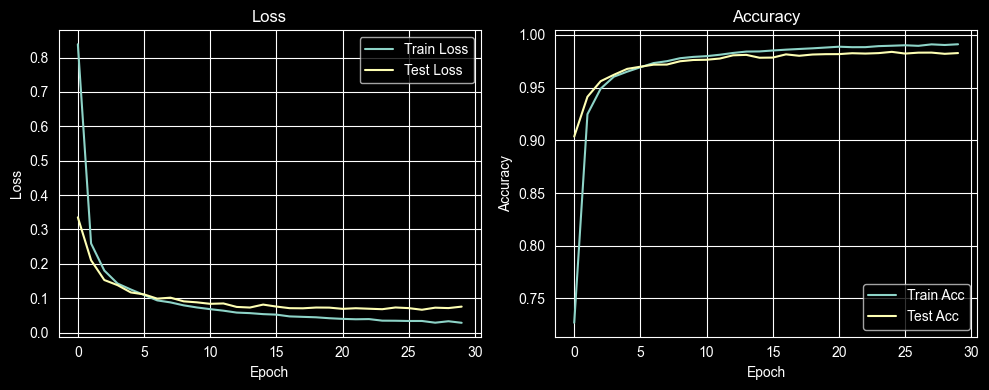

In [16]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["test_loss"], label="Test Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["test_acc"], label="Test Acc")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
from dllib.losses import softmax

test_logits = model.forward(x_test_new)
test_probs = softmax(test_logits)
y_test_np = device.to_cpu(y_test_new)
y_pred_test = device.to_cpu(device.xp.argmax(test_probs, axis=1))

cm = confusion_matrix(y_test_np, y_pred_test, labels=list(range(10)))
print("Матрица неточностей:")
print(cm)

accuracy = np.trace(cm) / np.sum(cm)
precision_per_class = np.divide(
    np.diag(cm),
    cm.sum(axis=0),
    out=np.zeros(10, dtype=float),
    where=cm.sum(axis=0) != 0,
)
recall_per_class = np.divide(
    np.diag(cm),
    cm.sum(axis=1),
    out=np.zeros(10, dtype=float),
    where=cm.sum(axis=1) != 0,
)
f1_per_class = np.divide(
    2 * precision_per_class * recall_per_class,
    precision_per_class + recall_per_class,
    out=np.zeros(10, dtype=float),
    where=(precision_per_class + recall_per_class) != 0,
)

print("\nКлассификационный отчет:")
print(classification_report(y_test_np, y_pred_test, digits=4))

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (macro): {precision_per_class.mean():.4f}")
print(f"Recall (macro): {recall_per_class.mean():.4f}")
print(f"F1 (macro): {f1_per_class.mean():.4f}")


Матрица неточностей:
[[2070    0    0    2    1    1    5    0    2    1]
 [   1 2332    4    1    2    1    1    3    5    1]
 [   1    7 2026    8    1    0    0   15   10    2]
 [   1    1    3 2106    0    8    0    7    5    2]
 [   0    3    1    0 2057    1    2    2    2    4]
 [   1    1    0   10    1 1932    6    2    3    3]
 [   2    3    1    1    3    6 2032    0    2    0]
 [   0    0    1    1    3    0    0 2091    3    3]
 [   6    2    1    4    4    9    4    2 2066    3]
 [   4    3    0    2   24    7    0   10    8 2022]]

Классификационный отчет:
              precision    recall  f1-score   support

           0     0.9923    0.9942    0.9933      2082
           1     0.9915    0.9919    0.9917      2351
           2     0.9946    0.9787    0.9866      2070
           3     0.9864    0.9873    0.9869      2133
           4     0.9814    0.9928    0.9870      2072
           5     0.9832    0.9862    0.9847      1959
           6     0.9912    0.9912    0.9912

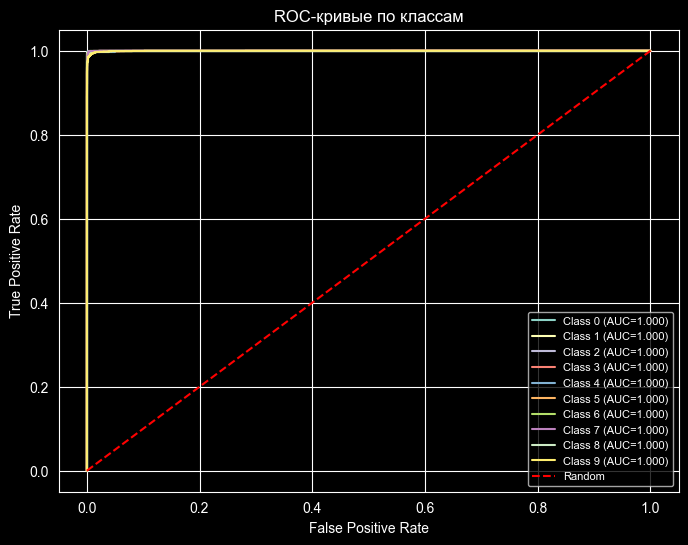

Mean AUC: 0.9998


In [18]:
y_test_binarized = label_binarize(y_test_np, classes=np.arange(10))
probs_cpu = device.to_cpu(test_probs)
auc_scores = []

plt.figure(figsize=(8, 6))
for i in range(10):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], probs_cpu[:, i])
    roc_auc = auc(fpr, tpr)
    auc_scores.append(roc_auc)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC={roc_auc:.3f})")

plt.plot([0, 1], [0, 1], "r--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривые по классам")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.show()

print(f"Mean AUC: {np.mean(auc_scores):.4f}")


Ошибочно классифицировано: 266 образцов из 21000


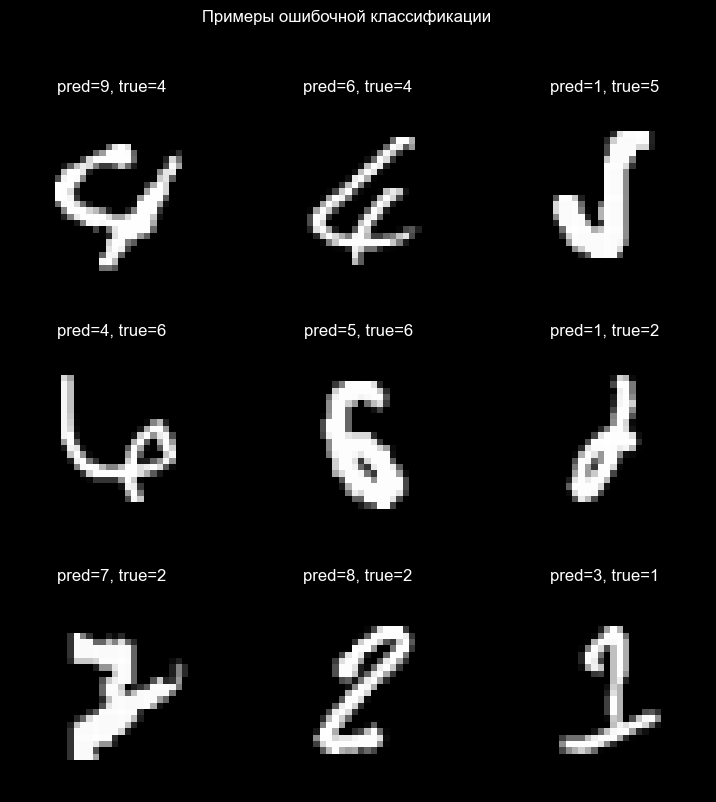

In [19]:
misclassified_idx = np.where(y_pred_test != y_test_np)[0]
print(f"Ошибочно классифицировано: {misclassified_idx.size} образцов из {y_test_np.size}")

if misclassified_idx.size:
    samples_to_show = misclassified_idx[:9]
    plt.figure(figsize=(9, 9))
    for i, idx in enumerate(samples_to_show):
        plt.subplot(3, 3, i + 1)
        plt.imshow(device.to_cpu(x_test_new[idx, 0]), cmap="gray")
        plt.title(f"pred={y_pred_test[idx]}, true={y_test_np[idx]}")
        plt.axis("off")
    plt.suptitle("Примеры ошибочной классификации")
    plt.show()
else:
    print("Ошибок на тесте не обнаружено")